In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

In [4]:
def convert_to_datetime(value):
    date_formats = ["%Y-%m-%d", "%Y/%m/%d", "%m/%d/%Y, %H:%M:%S", "%d %b %Y"]
    for fmt in date_formats:
        try:
            return datetime.strptime(value, fmt)
        except ValueError:
            continue
    return None

In [32]:
connections, devices, processes, profiles = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False), pd.read_csv('data/devices.csv', sep='\t', keep_default_na=False), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False), pd.read_csv('data/profiles.csv', sep='\t', keep_default_na=False)

## Missing values - deleting records

In [166]:
profiles = profiles[profiles['current_location'] != '']

## Non-uniform formats

Timestamp type correction

In [167]:
connections['ts'] = pd.to_datetime(connections['ts'])
processes['ts'] = pd.to_datetime(processes['ts'])

In [168]:
profiles['registration'] = profiles['registration'].apply(convert_to_datetime)

Conversion of the column current_location to two columns: latitude and longitude

In [169]:
latitudes = []
longitudes = []

for location in profiles['current_location']:
    if len(location) < 1:
        latitudes.append(None)
        longitudes.append(None)
        continue
    loc = location.replace("Decimal(", "").replace(")", "").replace(" ", "").replace("'", "").replace("(", "")
    lat, lon = loc.split(",")
    lat = float(lat.strip())
    lon = float(lon.strip())

    latitudes.append(lat)
    longitudes.append(lon)

profiles['latitude'] = latitudes
profiles['longitude'] = longitudes

profiles.drop(columns=['current_location'], inplace=True)

## Inappropriate data structure

Split column location in table devices to two columns: continent and city

In [170]:
continents, cities = [], []

for location in devices['location']:
    if len(location) > 0:
        continent, city = location.split("/", 1)
        continents.append(continent)
        cities.append(city)
    else:
        continents.append(None)
        cities.append(None)

devices['continent'] = continents
devices['city'] = cities

devices.drop(columns=['location'], inplace=True)

## Duplicate values

In [173]:
print("Number of records before deleting duplicates")
print("Connections: ", connections.shape[0])
print("Devices: ", devices.shape[0])
print("Profiles: ", profiles.shape[0])
print("Processes: ", processes.shape[0])

Number of records before deleting duplicates
Connections:  15074
Devices:  2895
Profiles:  2475
Processes:  15074


In [174]:
connections = connections.drop_duplicates()
devices = devices.drop_duplicates()
profiles = profiles.drop_duplicates()
processes = processes.drop_duplicates()

In [175]:
print("Number of records after deleting duplicates")
print("Connections: ", connections.shape[0])
print("Devices: ", devices.shape[0])
print("Profiles: ", profiles.shape[0])
print("Processes: ", processes.shape[0])

Number of records after deleting duplicates
Connections:  14895
Devices:  2883
Profiles:  2475
Processes:  14895


## Missing values - replacing with constant value

In [171]:
profiles['residence'] = np.where(profiles['residence'] == '', 'Unknown', profiles['residence'])
profiles['address'] = np.where(profiles['address'] == '', 'Unknown', profiles['address'])

In [172]:
profiles.head()

,name,mail,registration,job,ssn,company,username,imei,residence,user_id,address,latitude,longitude
0,Matthew Powell,floreseugene@yahoo.com,2024-03-14,Unknown,219-60-6090,Hicks-Drake,kcalderon,3590433799317661974,Unknown,2401,"84859 Nunez Lock Suite 082\nWest Rossside, HI ...",-27.447495,-43.231283
1,Nicole Richards,fthompson@gmail.com,2023-01-13,Unknown,049-88-9351,"Nguyen, White and Lopez",pgarcia,8630330696303481198,"662 Christopher Point\nWest Matthew, VT 84352",1147,"9123 Traci Pines\nLindastad, ME 99569",39.235450,138.429324
2,Andrew Smith,megan89@yahoo.com,2019-04-17,Unknown,039-54-7186,Navarro-Goodman,sramos,8630330696303482071,"9912 Jasmine Extension Suite 310\nDianeville, ...",459,"523 Suarez Port Apt. 013\nKellybury, MS 63150",-22.094944,-141.211383
3,Shane Williams,osimmons@hotmail.com,2023-09-09,"Administrator, Civil Service",453-34-1867,"Brown, Compton and Thompson",ioneill,863033069630348826,Unknown,1587,"4827 Morgan Mission\nWest Michaelborough, AL 1...",39.965278,-39.378417
5,Debra Duncan,lindawebster@yahoo.com,2018-04-24,Unknown,100-29-5185,"Bowen, Smith and Sanchez",karen44,3590433799317661321,"PSC 5534, Box 8755\nAPO AP 13717",2257,Unknown,-9.258064,-170.595126


## Missing values - replacing value with mode

Replacing empty records with modus.

In [16]:
filtered_mode = profiles['job'][profiles['job'].notna() & (profiles['job'] != '')].mode()
profiles['job'] = np.where(profiles['job'] == '', filtered_mode, profiles['job'])

0    Sports development officer
Name: job, dtype: object


In [17]:
profiles.head()

,name,mail,registration,job,ssn,company,current_location,username,imei,residence,user_id,address
0,Matthew Powell,floreseugene@yahoo.com,14 Mar 2024,Sports development officer,219-60-6090,Hicks-Drake,"(Decimal('-27.447495'), Decimal('-43.231283'))",kcalderon,3590433799317661974,,2401,"84859 Nunez Lock Suite 082\nWest Rossside, HI ..."
1,Nicole Richards,fthompson@gmail.com,2023-01-13,Sports development officer,049-88-9351,"Nguyen, White and Lopez","(Decimal('39.235450'), Decimal('138.429324'))",pgarcia,8630330696303481198,"662 Christopher Point\nWest Matthew, VT 84352",1147,"9123 Traci Pines\nLindastad, ME 99569"
2,Andrew Smith,megan89@yahoo.com,17 Apr 2019,Sports development officer,039-54-7186,Navarro-Goodman,"(Decimal('-22.094944'), Decimal('-141.211383'))",sramos,8630330696303482071,"9912 Jasmine Extension Suite 310\nDianeville, ...",459,"523 Suarez Port Apt. 013\nKellybury, MS 63150"
3,Shane Williams,osimmons@hotmail.com,2023-09-09,"Administrator, Civil Service",453-34-1867,"Brown, Compton and Thompson","(Decimal('39.9652785'), Decimal('-39.378417'))",ioneill,863033069630348826,,1587,"4827 Morgan Mission\nWest Michaelborough, AL 1..."
4,Patricia Leach,prodriguez@yahoo.com,"01/30/2018, 00:00:00",Sports development officer,785-50-4993,Pratt PLC,,michaelhart,359043379931766403,,2312,"48666 William View\nEricbury, OH 12135"


## Deviated values - replacing with cutoff values

<Axes: ylabel='c.dogalize'>

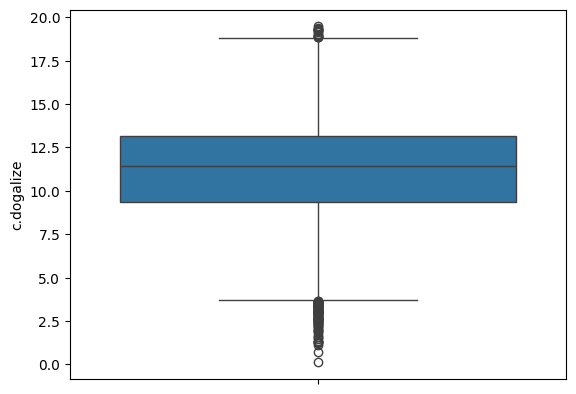

In [19]:
sns.boxplot(connections['c.dogalize'])

In [20]:
lower = connections['c.dogalize'].quantile(0.25) - 1.5 * stats.iqr(connections['c.dogalize'])
upper = connections['c.dogalize'].quantile(0.75) + 1.5 * stats.iqr(connections['c.dogalize'])

connections['c.dogalize'] = np.where(connections['c.dogalize'] < lower, lower, connections['c.dogalize'])
connections['c.dogalize'] = np.where(connections['c.dogalize'] > upper, upper, connections['c.dogalize'])

<Axes: ylabel='c.dogalize'>

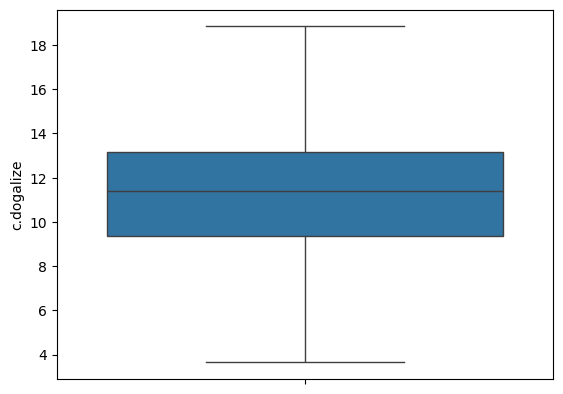

In [21]:
sns.boxplot(connections['c.dogalize'])

## Deviated values - removing records

<Axes: ylabel='c.android.youtube'>

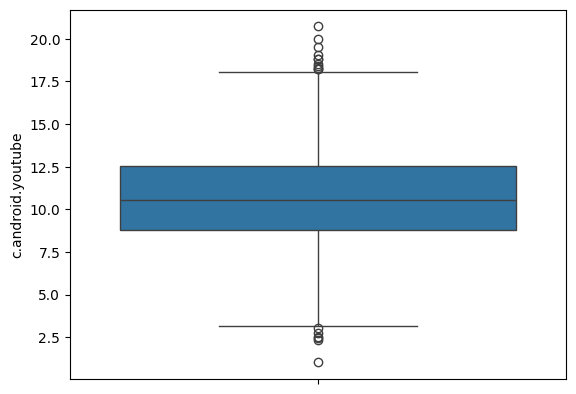

In [33]:
sns.boxplot(connections['c.android.youtube'])

In [34]:
lower = connections['c.android.youtube'].quantile(0.25) - 1.5 * stats.iqr(connections['c.android.youtube'])
upper = connections['c.android.youtube'].quantile(0.75) + 1.5 * stats.iqr(connections['c.android.youtube'])

connections = connections[(connections['c.android.youtube'] >= lower) & (connections['c.android.youtube'] <= upper)]


<Axes: ylabel='c.android.youtube'>

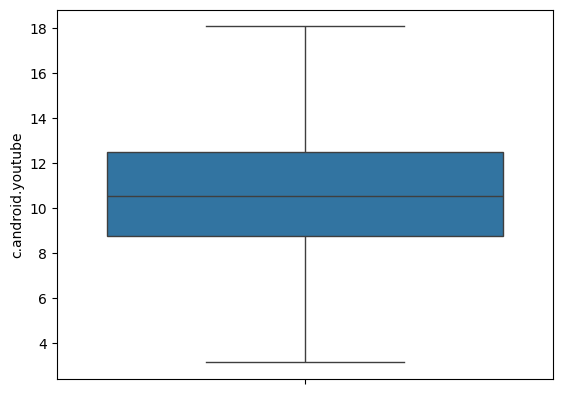

In [35]:
sns.boxplot(connections['c.android.youtube'])